# 决策树分类 Decision Tree Classifier
## 算法实现 implementation of algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

### 数据集 Dataset

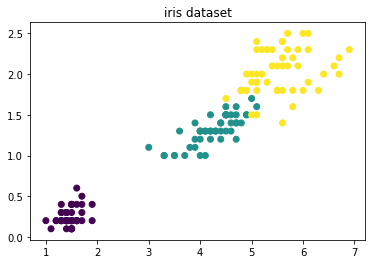

In [2]:
iris = load_iris()
X,y = iris.data[:,[2,3]], iris.target
X_train,X_test,y_train,y_test = train_test_split(X,y)

plt.scatter(X[:,0], X[:,1], c=y)
plt.title("iris dataset")
plt.show()

In [3]:
from collections import Counter
class DecisionTreeClassifier():
    def __init__(self):
        '''
        树数据结构：
                根
              (元素)
        (feature,threshold)
                /\
               /  \
              /    \
           左子树 右子树
           (元素) (元素)
            /  \   /  \
           叶  叶 ...
         (类别)
        '''
        self.tree = None
        
    def split(self, X, y, feature, value):
        '''
        分割子树，返回左右子树
        '''
        index_l = (X[:,feature] <= value)
        index_r = (X[:,feature] > value)
        return X[index_l], X[index_r], y[index_l], y[index_r]

    def entropy(self, y):
        '''
        计算熵值
        '''
        counter = Counter(y)
        ent = 0.0
        for num in counter.values():
            p = num / len(y)
            ent += -p * np.log(p)
        return ent

    def find_best_split(self, X, y):
        '''
        寻找最佳分割特征以及阈值
        '''
        best_entropy = float('inf')
        best_feature, threshold = -1, -1
        n_samples, n_features = X.shape
        for feature in range(n_features):
            sorted_index = np.argsort(X[:,feature])
            for i in range(1, len(X)):
                if X[sorted_index[i], feature] != X[sorted_index[i-1], feature]:
                    value = (X[sorted_index[i], feature] + X[sorted_index[i-1], feature]) / 2
                    X_l, X_r, y_l, y_r = self.split(X, y, feature, value)
                    e = len(y_l)/len(y) * self.entropy(y_l) + len(y_r)/len(y) * self.entropy(y_r)
                    if e < best_entropy:
                        best_entropy, best_feature, threshold = e, feature, value
        return {'feature':best_feature, 'threshold':threshold}
    
    def create_leaf(self, y):
        '''
        构建叶子节点
        '''
        classification = max(set(y), key=list(y).count)
        return classification
    
    def build_tree(self, X_train, y_train, node, depth, max_depth, min_samples):
        '''
        构建当前节点的树
        '''
        left_samples, right_samples, y_left_samples, y_right_samples = self.split(X_train, y_train, node['feature'], node['threshold'])

        if len(y_left_samples) == 0 or len(y_right_samples) == 0:
            node["left_child"] = node["right_child"] = self.create_leaf(np.append(y_left_samples, y_right_samples))
            return None

        if depth >= max_depth:
            node["left_child"] = self.create_leaf(y_left_samples)
            node["right_child"] = self.create_leaf(y_right_samples)
            return None

        if len(right_samples) < min_samples:
            node["right_child"] = self.create_leaf(y_right_samples)
        else:
            node["right_child"] = self.find_best_split(right_samples, y_right_samples)
            self.build_tree(right_samples, y_right_samples, node["right_child"], depth+1, max_depth, min_samples)

        if len(left_samples) < min_samples:
            node["left_child"] = self.create_leaf(y_left_samples)
        else:
            node["left_child"] = self.find_best_split(left_samples, y_left_samples)
            self.build_tree(left_samples, y_left_samples, node["left_child"], depth+1, max_depth, min_samples)

        return node
    
    def fit(self, X_train, y_train, max_depth, min_samples):
        root = self.find_best_split(X, y)
        self.tree = self.build_tree(X_train, y_train, root, 1, max_depth, min_samples)
        if self.tree is None:
            self.tree = root
    
    def predict(self, X_test, node=None):
        if node is None:
            node = self.tree
        feature = node['feature']
        threshold = node['threshold']
        if X_test[feature] < threshold:
            if isinstance(node['left_child'], (int, np.integer)):
                return node['left_child']
            else:
                prediction = self.predict(X_test, node['left_child'])
        elif X_test[feature] >= threshold:
            if isinstance(node['right_child'], (int, np.integer)):
                return node['right_child']
            else:
                prediction = self.predict(X_test, node['right_child'])
        return prediction

### 测试 Testing

In [4]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train, max_depth=2, min_samples=1)
y_p_test = np.array([clf.predict(x) for x in X_test])
test_acc = np.sum(y_p_test == y_test)/len(y_p_test) * 100
print(f"Test accuracy from scratch: {test_acc}%\n")
clf.tree

Test accuracy from scratch: 97.36842105263158%

{'feature': 0, 'threshold': 2.45, 'right_child': {'feature': 1, 'threshold': 1.75, 'left_child': 1, 'right_child': 2}, 'left_child': {'feature': 0, 'threshold': 1.05, 'left_child': 0, 'right_child': 0}}


### 决策边界可视化 Visualize decision boundary

In [5]:
def plot_decision_boundary(clf, X, y): 
    # Plotting decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z =  np.array([clf.predict(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    from matplotlib.colors import ListedColormap
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    plt.contourf(xx, yy, Z, cmap=cmap_light)

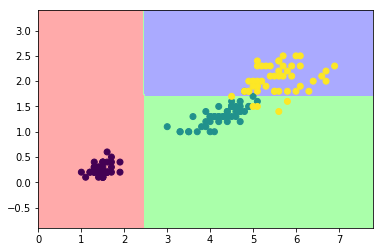

In [6]:
plot_decision_boundary(clf, X, y)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

## scikit-learn

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [8]:
dt_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy")
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)

0.9736842105263158

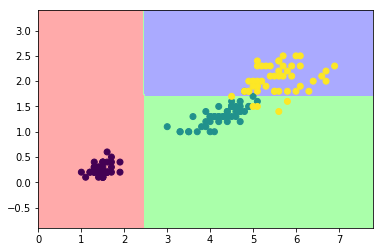

In [9]:
def plot_decision_boundary(clf, X, y): 
    # Plotting decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    from matplotlib.colors import ListedColormap
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    plt.contourf(xx, yy, Z, cmap=cmap_light)

plot_decision_boundary(dt_clf, X, y)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()